In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/hayasakaist/Trajectory_Optimization/coordinate.py:256: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  if u.dot(normalize(pos_eci)) > 0.999999:
/home/hayasakaist/Trajectory_Optimization/coordinate.py:282: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  inclination_rad = acos(c1_eci.dot(np.array([0.0,0.0,1.0])))
/home/hayasakaist/Trajectory_Optimization/coordinate.py:287: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  argument_perigee = acos(n_eci.dot(normalize(f_eci)))
/home/hayasakaist/Trajectory_Optimization/optimization6DoFquat.py:780: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  lh = D.dot(x / unit_x)
/home/hayasakaist/Trajectory_Optimization/optimization6DoFquat.py:801

6578.137

List of user-set options:

                                    Name   Value                used
                        file_print_level = 5                     yes
                   hessian_approximation = limited-memory        yes
                           linear_solver = pardisomkl            yes
                                max_iter = 300                   yes
                             output_file = Zero-east_2022-03-28-181620_pyIPOPT.out  yes
                             print_level = 3                     yes
                 print_timing_statistics = yes                   yes
                      print_user_options = yes                   yes
                                      sb = yes                   yes
                                     tol = 1e-10                 yes
Total number of variables............................:     1097
                     variables with only lower bounds:        0
                variables with lower and upper bounds:   

NameError: name 'x_res' is not defined

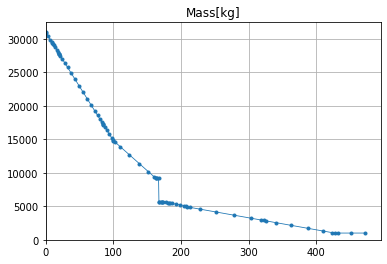

In [2]:
%run -i Trajectory_Optimization.py Zero-east-settings.json

In [9]:
def output_6DoF(xdict, unitdict, tx_res, tu_res, pdict):
    
        
    N = len(tx_res)

    unit_mass= unitdict["mass"]
    unit_pos = unitdict["position"]
    unit_vel = unitdict["velocity"]
    unit_u = unitdict["u"]
    unit_t = unitdict["t"]

    mass_ = xdict["mass"] * unit_mass
    pos_ = xdict["position"].reshape(-1,3) * unit_pos
    vel_ = xdict["velocity"].reshape(-1,3) * unit_vel
    quat_ = xdict["quaternion"].reshape(-1,4)
    
    u_ = xdict["u"].reshape(-1,3) * unit_u
    
    
    out = { "time"       : tx_res,
            "section"    : np.zeros(N),
            "thrust"     : np.zeros(N),
            "mass"       : mass_,
            "lat"        : np.zeros(N),
            "lon"        : np.zeros(N),
            "alt"        : np.zeros(N),
            "ha"         : np.zeros(N),
            "hp"         : np.zeros(N),
            "inc"        : np.zeros(N),
            "argp"       : np.zeros(N),
            "asnd"       : np.zeros(N),
            "tanm"       : np.zeros(N),
            "pos_ECI_X"  : pos_[:,0],
            "pos_ECI_Y"  : pos_[:,1],
            "pos_ECI_Z"  : pos_[:,2],
            "vel_ECI_X"  : vel_[:,0],
            "vel_ECI_Y"  : vel_[:,1],
            "vel_ECI_Z"  : vel_[:,2],
            "vel_NED_X"  : np.zeros(N),
            "vel_NED_Y"  : np.zeros(N),
            "vel_NED_Z"  : np.zeros(N),
            "quat_i2b_0" : quat_[:,0],
            "quat_i2b_1" : quat_[:,1],
            "quat_i2b_2" : quat_[:,2],
            "quat_i2b_3" : quat_[:,3],
            "accel_X"    : np.zeros(N),
            "aero_X"     : np.zeros(N),
            "heading"    : np.zeros(N),
            "pitch"      : np.zeros(N),
            "roll"       : np.zeros(N),
            "vi"         : norm(vel_,axis=1),
            "fpvgd"      : np.zeros(N),
            "azvgd"      : np.zeros(N),
            "thrustvec_X": np.zeros(N),
            "thrustvec_Y": np.zeros(N),
            "thrustvec_Z": np.zeros(N),
            "rate_P"     : np.interp(tx_res, tu_res, u_[:,0]),
            "rate_Q"     : np.interp(tx_res, tu_res, u_[:,1]),
            "rate_R"     : np.interp(tx_res, tu_res, u_[:,2]),
            "vr"         : np.zeros(N),
            "va"         : np.zeros(N),
            "aoa_total"  : np.zeros(N),
            "aoa_alpha"  : np.zeros(N),
            "aoa_beta"   : np.zeros(N),
            "q"          : np.zeros(N),
            "M"          : np.zeros(N)
        }
    
    section = 0

    for i in range(N):
        
        mass = mass_[i]
        pos = pos_[i]
        vel = vel_[i]
        quat = normalize(quat_[i])
        t = tx_res[i]
        
        if t >= pdict["params"][section]["timeFinishAt_sec"]:
            section += 1
        thrust_vac_n = pdict["params"][section]["thrust_n"]
        massflow_kgps = pdict["params"][section]["massflow_kgps"]
        airArea_m2 = pdict["params"][section]["airArea_m2"]
        nozzleArea_m2 = pdict["params"][section]["nozzleArea_m2"]
        out["section"][i] = section

        pos_llh = eci2geodetic(pos, t)
        altitude_m = geopotential_altitude(pos_llh[2])
        out["lat"][i]  = pos_llh[0]
        out["lon"][i]  = pos_llh[1]
        out["alt"][i]  = pos_llh[2] / 1000.0
        
        elem = orbital_elements(pos, vel)
        out["ha"][i] = elem[0] * (1.0 + elem[1]) / 1000.0 - 6378.137
        out["hp"][i] = elem[0] * (1.0 - elem[1]) / 1000.0 - 6378.137
        out["inc"][i], out["asnd"][i], out["argp"][i], out["tanm"][i] = elem[2:6]
        
        vel_ground_ecef = vel_eci2ecef(vel, pos, t)
        vel_ground_ned  = quatrot(quat_ecef2nedg(eci2ecef(pos, t)), vel_ground_ecef)
        out["vel_NED_X"][i], out["vel_NED_Y"][i], out["vel_NED_Z"][i] = vel_ground_ned
        vel_ned         = quatrot(quat_eci2nedg(pos, t), vel)
        vel_air_ned     = vel_ground_ned - wind_ned(altitude_m, pdict["wind_table"])
        out["vr"][i] = norm(vel_ground_ecef)
        
        out["azvgd"][i] = degrees(atan2(vel_ned[1], vel_ned[0]))
        out["fpvgd"][i] = degrees(asin(-vel_ned[2] / norm(vel_ned)))
        
        q = 0.5 * norm(vel_air_ned)**2 * airdensity_at(pos_llh[2])
        out["q"][i] = q
        
        aoa_all_deg = angle_of_attack_all_rad(pos, vel, quat, t, pdict["wind_table"]) * 180.0 / np.pi
        aoa_ab_deg = angle_of_attack_ab_rad(pos, vel, quat, t, pdict["wind_table"]) * 180.0 / np.pi
        
        out["aoa_total"][i] = aoa_all_deg
        out["aoa_alpha"][i], out["aoa_beta"][i] = aoa_ab_deg

        thrustdir_eci = quatrot(conj(quat), np.array([1.0, 0.0, 0.0]))
        out["thrustvec_X"][i], out["thrustvec_Y"][i], out["thrustvec_Z"][i] = thrustdir_eci
        euler = euler_from_quat(quat_nedg2body(quat, pos, t))
        out["heading"][i] = euler[0]
        out["pitch"][i]   = euler[1]
        out["roll"][i]    = euler[2]

        #####
        rho = airdensity_at(altitude_m)
        p = airpressure_at(altitude_m)

        
        #対気速度
        
        vel_ecef = vel_eci2ecef(vel, pos, t)
        vel_wind_ned = wind_ned(altitude_m, pdict["wind_table"])
        
        vel_wind_eci = quatrot(quat_nedg2eci(pos, t), vel_wind_ned)
        vel_air_eci = ecef2eci(vel_ecef, t) - vel_wind_eci
        mach_number = norm(vel_air_eci) / speed_of_sound(altitude_m)
        airAxialForce_coeff = np.interp(mach_number, pdict["ca_table"][:,0], pdict["ca_table"][:,1])
        out["va"][i] = norm(vel_air_eci)        
        
        ret = np.zeros(11)
        
        aero_n_eci = 0.5 * rho * norm(vel_air_eci) * -vel_air_eci * airArea_m2 * airAxialForce_coeff
        aero_n_body = quatrot(quat, aero_n_eci)

        thrust_n = thrust_vac_n - nozzleArea_m2 * p
        out["thrust"][i] = thrust_n
        thrustdir_eci = quatrot(conj(quat), np.array([1.0, 0.0, 0.0]))
        thrust_n_eci = thrustdir_eci * thrust_n
        gravity_eci = gravity(pos)
        out["aero_X"][i] = aero_n_body[0]
        out["accel_X"][i] = (thrust_n + aero_n_body[0]) / mass
        
        acc_eci = gravity_eci + (thrust_n_eci + aero_n_eci) / mass
        
        #####
        
    return pd.DataFrame(out)


initial mass          : 30938.201000788325 kg
payload + fairing     : 198.20100078832547 kg


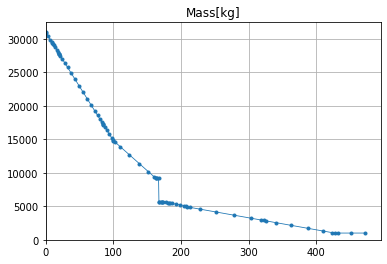

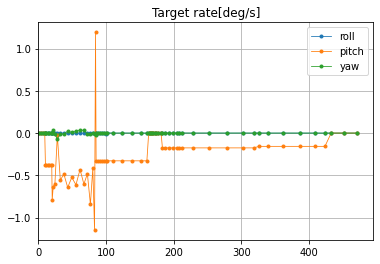

In [10]:

m_res = sol.xStar["mass"] * unitdict["mass"]

plt.figure()
plt.title("Mass[kg]")
plt.plot(tx_res, m_res, '.-', lw=0.8)
plt.grid()
plt.xlim([0,None])
plt.ylim([0,None])
if flag_savefig:
    plt.savefig("figures/mass.png")

print("initial mass          : {} kg".format(m_res[0]))
print("payload + fairing     : {} kg".format(m_res[0] - m_init))

plt.figure()
plt.title("Target rate[deg/s]")
plt.plot(tu_res, sol.xStar["u"].reshape(-1,3) * unitdict["u"], '.-', lw=0.8, label=["roll", "pitch", "yaw"])
plt.grid()
plt.legend()
plt.xlim([0,None])
if flag_savefig:
    plt.savefig("figures/omega.png")

out = output_6DoF(sol.xStar, unitdict, tx_res, tu_res, pdict)

out.to_csv("{}_{}_pyIPOPT_result.csv".format(settings["name"], timestamp))

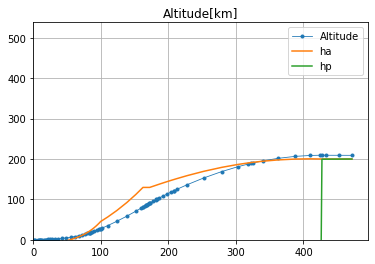

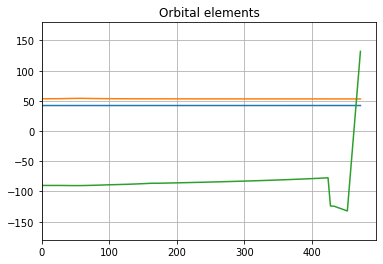

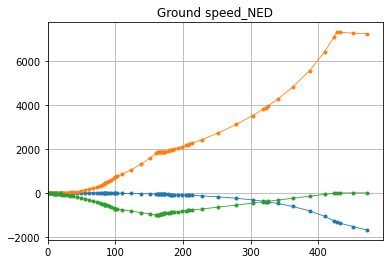

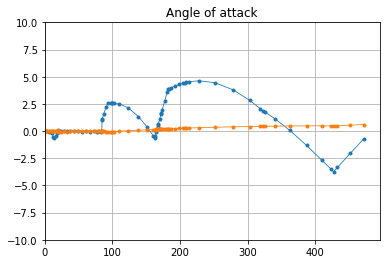

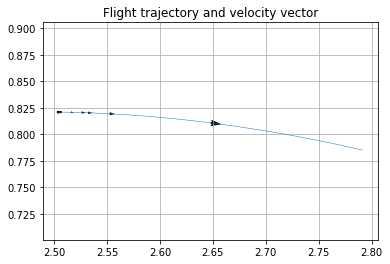

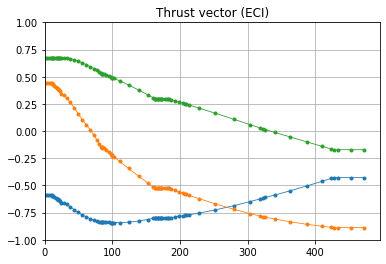

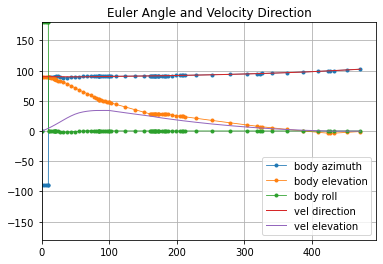

In [11]:
display_6DoF(out)

In [12]:
out.loc[:,["time","heading","pitch","roll"]].to_csv("../RocketSim/bin/input/OptResult-Attitude.csv",index=None)

In [13]:
ref = pd.read_csv("ALMA/ZERO_NOMINAL_2201.csv",skiprows=[0,1,2])

In [14]:
df = pd.read_csv("../RocketSim/bin/output/OptResult-out.csv")

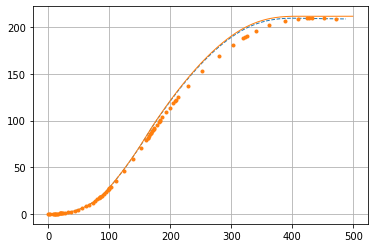

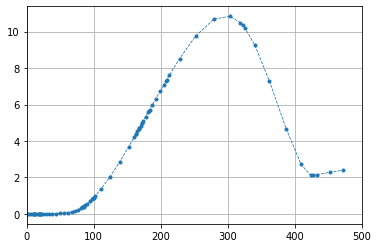

In [15]:
plt.plot(ref["time"],ref["h"],"--",lw=1)
plt.plot(out["time"],out["alt"],".")
plt.plot(df["time"],df["alt"],c="C1",lw=1)
plt.grid()

df1  = np.interp(out["time"], df["time"], df["alt"])
plt.figure()
plt.plot(out["time"], df1-out["alt"], ".--", lw=0.8)
plt.xlim([0,500])
plt.grid()

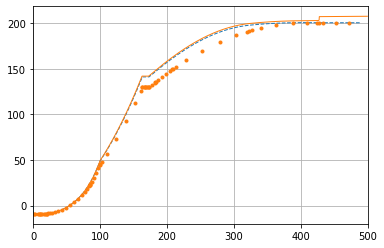

In [16]:
plt.plot(ref["time"], ref["ha"], "--",lw=1)
plt.plot(out["time"], out["ha"],".")
plt.plot(df["time"], df["ha"],c="C1",lw=1)
plt.xlim([0,500])
plt.ylim([-20,None])
plt.grid()


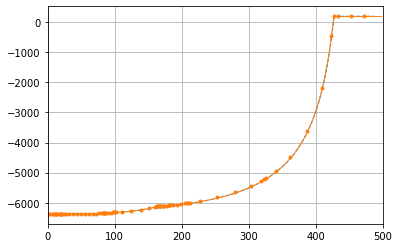

In [17]:
plt.plot(ref["time"], ref["hp"], "--",lw=1)
plt.plot(out["time"], out["hp"],".")
plt.plot(df["time"], df["hp"],c="C1",lw=1)
plt.xlim([0,500])
plt.grid()


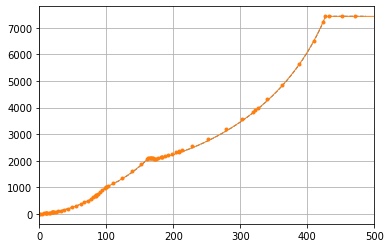

In [18]:
plt.plot(ref["time"],ref["vr"],"--",lw=1)
plt.plot(out["time"],out["vr"],".")
plt.plot(df["time"],df["vel_ground"],c="C1",lw=1)
plt.xlim([0,500])
plt.grid()


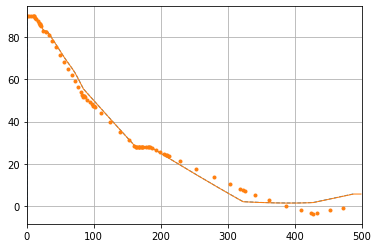

In [19]:
plt.plot(ref["time"],ref["eularGDB[1]"],"--",lw=1)
plt.plot(out["time"],out["pitch"],".")
plt.plot(df["time"],df["pitch"].to_numpy('f8'),c="C1",lw=1)
plt.xlim([0,500])
plt.grid()


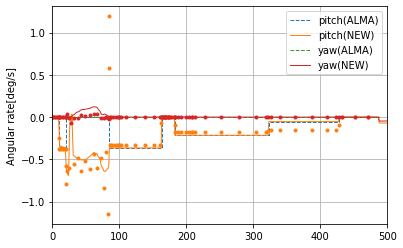

In [20]:
plt.plot(ref["time"],ref["Q"],"--",lw=1,label="pitch(ALMA)")
plt.plot(out["time"],out["rate_Q"],".")
plt.plot(df["time"],df["rate_Q"]*180/np.pi,c="C1",lw=1,label="pitch(NEW)")
plt.plot(ref["time"],ref["R"],"--",lw=1,label="yaw(ALMA)")
plt.plot(out["time"],out["rate_R"],".")
plt.plot(df["time"],df["rate_R"]*180/np.pi,c="C3",lw=1,label="yaw(NEW)")

plt.xlim([0,500])
plt.ylabel("Angular rate[deg/s]")
plt.legend()
plt.grid()

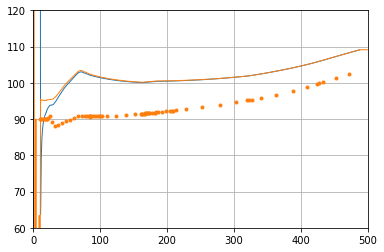

In [21]:
plt.plot(ref["time"],ref["eularGDB[2]"],lw=1)
plt.plot(out["time"],out["heading"],".")
plt.plot(df["time"],df["heading"].to_numpy('f8'),c="C1",lw=1)
plt.xlim([0,500])
plt.ylim([60,120])
plt.grid()

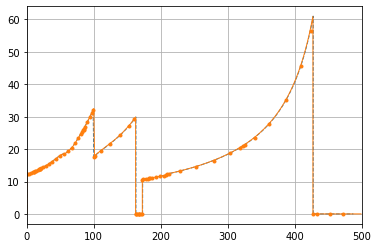

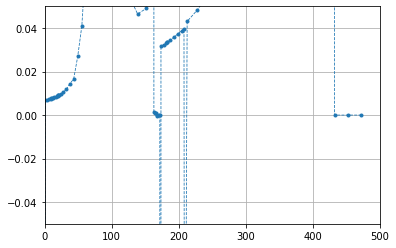

In [22]:
plt.plot(ref["time"],ref["axb"],"--",lw=1)
plt.plot(out["time"],out["accel_X"],".")
plt.plot(df["time"],df["acc_BODY_X"],c="C1",lw=1)
plt.xlim([0,500])
plt.grid()

df1  = np.interp(out["time"], df["time"], df["acc_BODY_X"])
plt.figure()
plt.plot(out["time"], df1-out["accel_X"], ".--", lw=0.8)
plt.xlim([0,500])
plt.ylim([-0.05,0.05])
plt.grid()

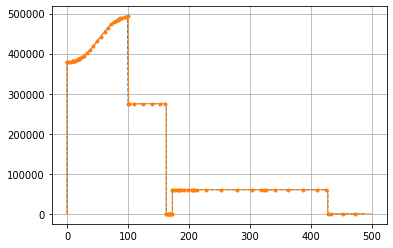

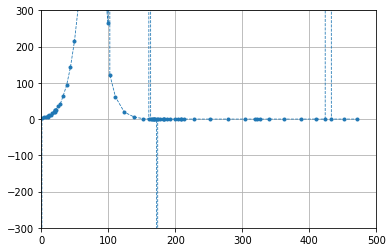

In [23]:
plt.plot(ref["time"],ref["Fr"],"--",lw=1)
plt.plot(out["time"],out["thrust"],".")
plt.plot(df["time"],df["thrust"],c="C1",lw=1)
plt.grid()

df1  = np.interp(out["time"], df["time"], df["thrust"])
plt.figure()
plt.plot(out["time"], df1-out["thrust"], ".--", lw=0.8)
plt.xlim([0,500])
plt.ylim([-300,300])
plt.grid()

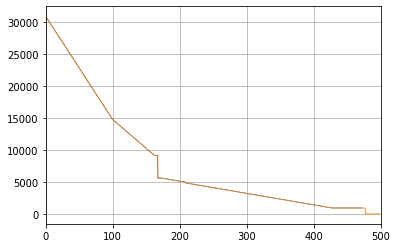

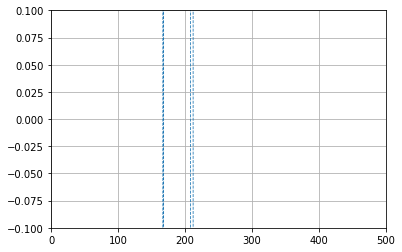

In [24]:
#plt.plot(ref["time"],ref["weight"])
plt.plot(out["time"],out["mass"],lw=0.8)
plt.plot(df["time"],df["total mass"],lw=0.8)
plt.xlim([0,500])
plt.grid()

df1  = np.interp(out["time"], df["time"], df["total mass"])
plt.figure()
plt.plot(out["time"], df1-out["mass"], ".--", lw=0.8)
plt.xlim([0,500])
plt.ylim([-0.1,0.1])
plt.grid()

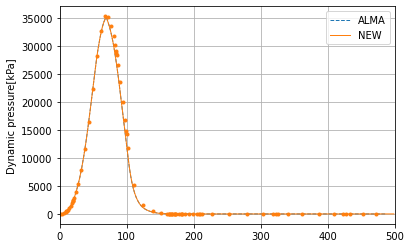

In [25]:
plt.plot(ref["time"],ref["q"],"--",lw=1,label="ALMA")
plt.plot(out["time"],out["q"],".")
plt.plot(df["time"],df["q"],c="C1",lw=1,label="NEW")
plt.xlim([0,500])
plt.ylabel("Dynamic pressure[kPa]")
plt.legend()
plt.grid()

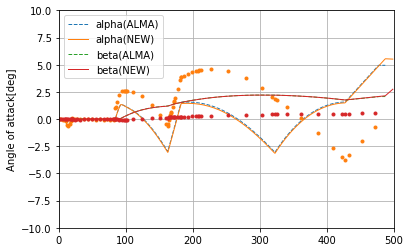

In [26]:
plt.plot(ref["time"],ref["alpha"],"--",lw=1,label="alpha(ALMA)")
plt.plot(out["time"],out["aoa_alpha"],".")
plt.plot(df["time"],df["aoa_alpha"],c="C1",lw=1,label="alpha(NEW)")
plt.plot(ref["time"],ref["beta"],"--",lw=1,label="beta(ALMA)")
plt.plot(out["time"],out["aoa_beta"],".")
plt.plot(df["time"],df["aoa_beta"],c="C3",lw=1,label="beta(NEW)")

plt.xlim([0,500])
plt.ylim([-10,10])
plt.legend()
plt.ylabel("Angle of attack[deg]")
plt.grid()

KeyError: 'aoa_total'

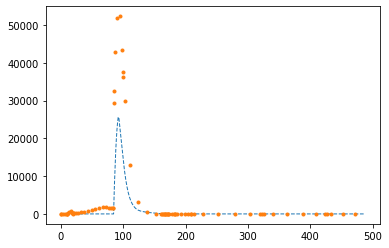

In [27]:
plt.plot(ref["time"],ref["alphaq"],"--",lw=1,label="ALMA")
plt.plot(out["time"],out["q"]*out["aoa_total"],".")
plt.plot(df["time"],df["q"]*df["aoa_total"],c="C1",lw=1,label="NEW")
plt.xlim([0,500])
plt.ylabel("Q-alpha[kPa-deg]")
plt.legend()
plt.grid()